<a href="https://colab.research.google.com/github/niyaak/WahanaSiKecil/blob/main/segmentasi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive to access data and save models
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score

drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import os
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint

# Verifikasi GPU
print("Is GPU available:", tf.test.is_gpu_available())
print("Available GPU:", tf.config.list_physical_devices('GPU'))

# Define paths and parameters
base_dir = '/content/drive/MyDrive/datasetld3kelas'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'valid')

img_height, img_width = 288, 512
batch_size = 8
learning_rate = 0.0001
epochs = 50
early_stop_patience = 10

# Function to load class mapping from _classes.csv in a specific folder
def load_classes(folder):
    classes_file = os.path.join(folder, '_classes.csv')
    print(f"Loading classes from {classes_file}...")
    df = pd.read_csv(classes_file)

    # Handle column names dynamically
    pixel_col = [col for col in df.columns if 'Pixel' in col][0]
    class_col = [col for col in df.columns if 'Class' in col][0]

    # Ensure proper mapping
    class_mapping = {}
    for _, row in df.iterrows():
        pixel_value = int(row[pixel_col])
        class_name = row[class_col].strip()
        class_mapping[pixel_value] = len(class_mapping)

    print(f"Loaded class mapping: {class_mapping}")
    return class_mapping

# Function to load and preprocess data
def load_data(folder):
    class_mapping = load_classes(folder)
    images, masks = [], []

    for file_name in os.listdir(folder):
        if file_name.endswith('.jpg'):
            img_path = os.path.join(folder, file_name)
            mask_path = os.path.join(folder, file_name.replace('.jpg', '_mask.png'))

            # Load and normalize the image
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img)

            # Load the mask
            mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(img_height, img_width), color_mode='grayscale')
            mask = tf.keras.preprocessing.image.img_to_array(mask).astype(np.uint8).squeeze()

            # Normalize mask pixel values to class indices
            for pixel_value, class_idx in class_mapping.items():
                mask[mask == pixel_value] = class_idx
            masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)
    masks = np.expand_dims(masks, axis=-1)  # Expand dimensions for compatibility
    return images, masks, len(class_mapping)

# Load training and validation data
print("Loading training data...")
train_images, train_masks, num_classes_train = load_data(train_dir)
print("Loading validation data...")
val_images, val_masks, num_classes_val = load_data(val_dir)

if num_classes_train != num_classes_val:
    raise ValueError("The number of classes in training and validation datasets are not the same.")

num_classes = num_classes_train

# Define U-Net model
def unet_model(input_size=(img_height, img_width, 3), num_classes=num_classes):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs, outputs)
    return model

# Build and compile the model
print("Building the model...")
model = unet_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('/content/drive/MyDrive/datasetld3kelas/best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=early_stop_patience, mode='max', verbose=1)

# Train the model
print("Training the model...")
history = model.fit(train_images, train_masks,
                    validation_data=(val_images, val_masks),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpoint, early_stopping])

# Evaluate precision, recall, and F1-score
def calculate_metrics(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return precision, recall, f1

print("Evaluating the model on validation set...")
val_preds = model.predict(val_images, batch_size=batch_size)
val_preds = np.argmax(val_preds, axis=-1)
precision, recall, f1 = calculate_metrics(val_masks, val_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Is GPU available: True
Available GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Loading training data...
Loading classes from /content/drive/MyDrive/datasetld3kelas/train/_classes.csv...
Loaded class mapping: {0: 0, 1: 1, 2: 2, 3: 3}
Loading validation data...
Loading classes from /content/drive/MyDrive/datasetld3kelas/valid/_classes.csv...
Loaded class mapping: {0: 0, 1: 1, 2: 2, 3: 3}
Building the model...
Training the model...
Epoch 1/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 284s 1s/step - accuracy: 0.6476 - loss: 0.9967 - val_accuracy: 0.8448 - val_loss: 0.4424
Epoch 2/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 183s 973ms/step - accuracy: 0.8219 - loss: 0.4936 - val_accuracy: 0.8552 - val_loss: 0.3846
Epoch 3/50
142/142 ━━━━━━━━━━━━━━━━━━━━ 143s 979ms/step - accuracy: 0.8330 - loss: 0.4245 - val_accuracy: 0.8583 - val_loss: 0.3509
Epoch 4/50
142/142 

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import os
import pandas as pd
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint

# Verifikasi GPU
print("Is GPU available:", tf.test.is_gpu_available())
print("Available GPU:", tf.config.list_physical_devices('GPU'))

# Define paths and parameters
base_dir = '/content/drive/MyDrive/datasetld3kelas'  # Update with your dataset path in Google Drive
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'valid')

img_height, img_width = 288, 512
batch_size = 8  # Meningkatkan batch size untuk GPU jika memori mencukupi

# Function to load class mapping from _classes.csv in a specific folder
def load_classes(folder):
    classes_file = os.path.join(folder, '_classes.csv')
    print(f"Loading classes from {classes_file}...")
    df = pd.read_csv(classes_file)

    # Debugging file columns
    print("Kolom di file _classes.csv:", df.columns.tolist())

    # Handle column names dynamically
    pixel_col = [col for col in df.columns if 'Pixel' in col][0]
    class_col = [col for col in df.columns if 'Class' in col][0]

    # Ensure proper mapping
    class_mapping = {}
    for _, row in df.iterrows():
        pixel_value = int(row[pixel_col])
        class_name = row[class_col].strip()  # Remove extra spaces
        class_mapping[pixel_value] = len(class_mapping)  # Assign unique numerical index

    print(f"Loaded class mapping: {class_mapping}")
    return class_mapping

# Function to load and preprocess data
def load_data(folder):
    class_mapping = load_classes(folder)  # Load class mapping for the folder
    images, masks = [], []

    for file_name in os.listdir(folder):
        if file_name.endswith('.jpg'):
            img_path = os.path.join(folder, file_name)
            mask_path = os.path.join(folder, file_name.replace('.jpg', '_mask.png'))

            # Load and normalize the image
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img)

            # Load the mask
            mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(img_height, img_width), color_mode='grayscale')
            mask = tf.keras.preprocessing.image.img_to_array(mask).astype(np.uint8).squeeze()

            # Normalize mask pixel values to class indices
            for pixel_value, class_idx in class_mapping.items():
                mask[mask == pixel_value] = class_idx
            masks.append(mask)

    images = np.array(images)
    masks = np.array(masks)
    masks = np.expand_dims(masks, axis=-1)  # Expand dimensions for compatibility
    return images, masks, len(class_mapping)

# Load training data and update num_classes
print("Loading training data...")
train_images, train_masks, num_classes_train = load_data(train_dir)
print("Loading validation data...")
val_images, val_masks, num_classes_val = load_data(val_dir)

# Ensure the same number of classes across train and val
if num_classes_train != num_classes_val:
    raise ValueError("The number of classes in training and validation datasets are not the same.")

num_classes = num_classes_train  # Set the number of classes

# Define U-Net model
def unet_model(input_size=(img_height, img_width, 3), num_classes=num_classes):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs, outputs)
    return model

# Build and compile the model
print("Building the model...")
model = unet_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
print("Training the model...")
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')

model.fit(train_images, train_masks,
          validation_data=(val_images, val_masks),
          epochs=50,
          batch_size=batch_size,
          callbacks=[checkpoint])


In [ ]:
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Verifikasi GPU
print("Available GPU:", tf.config.list_physical_devices('GPU'))

# Define paths and parameters
base_dir = '/content/drive/MyDrive/datasetld3kelas'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'valid')

img_height, img_width = 288, 512
batch_size = 16
learning_rate = 0.0001
epochs = 50
early_stop_patience = 5

# Class weights
class_weights = {0: 1.0, 1: 1.5, 2: 1.0, 3: 1.0}
loss = SparseCategoricalCrossentropy()

# Function to load class mapping
def load_classes(folder):
    classes_file = os.path.join(folder, '_classes.csv')
    if not os.path.exists(classes_file):
        raise FileNotFoundError(f"Classes file not found in {folder}")

    print(f"Loading classes from {classes_file}...")
    df = pd.read_csv(classes_file)
    pixel_col = [col for col in df.columns if 'Pixel' in col][0]
    class_col = [col for col in df.columns if 'Class' in col][0]
    class_mapping = {int(row[pixel_col]): idx for idx, row in df.iterrows()}
    print(f"Loaded class mapping: {class_mapping}")
    return class_mapping

# Function to load and preprocess data
def load_data(folder):
    try:
        class_mapping = load_classes(folder)
    except FileNotFoundError as e:
        print(e)
        return None, None, None

    images, masks = [], []
    for file_name in os.listdir(folder):
        if file_name.endswith('.jpg'):
            img_path = os.path.join(folder, file_name)
            mask_path = os.path.join(folder, file_name.replace('.jpg', '_mask.png'))

            if not os.path.exists(mask_path):
                print(f"Warning: Mask file not found for {file_name}")
                continue

            # Load and normalize the image
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
            img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img)

            # Load the mask
            mask = tf.keras.preprocessing.image.load_img(mask_path, target_size=(img_height, img_width), color_mode='grayscale')
            mask = tf.keras.preprocessing.image.img_to_array(mask).astype(np.uint8).squeeze()

            for pixel_value, class_idx in class_mapping.items():
                mask[mask == pixel_value] = class_idx
            masks.append(mask)

    if not images or not masks:
        raise ValueError("No valid data found in folder")

    images = np.array(images)
    masks = np.array(masks)
    masks = np.expand_dims(masks, axis=-1)
    return images, masks, len(class_mapping)

# Load training and validation data
print("Loading training data...")
train_images, train_masks, num_classes_train = load_data(train_dir)
print("Loading validation data...")
val_images, val_masks, num_classes_val = load_data(val_dir)

if num_classes_train != num_classes_val:
    raise ValueError("Number of classes in training and validation datasets are not the same.")

num_classes = num_classes_train

# Define U-Net model
def unet_model(input_size=(img_height, img_width, 3), num_classes=num_classes):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    return Model(inputs, outputs)

# Compile model
model = unet_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=loss,
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint('/content/drive/MyDrive/dataset3kelasrev/best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=early_stop_patience, mode='max', verbose=1)

# Train the model
print("Training the model...")
history = model.fit(train_images, train_masks,
                    validation_data=(val_images, val_masks),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[checkpoint, early_stopping])

# Evaluate precision, recall, and F1-score
val_preds = model.predict(val_images, batch_size=batch_size)
val_preds = np.argmax(val_preds, axis=-1)

def calculate_metrics(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    return precision, recall, f1

precision, recall, f1 = calculate_metrics(val_masks.flatten(), val_preds.flatten())
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Visualize sample prediction
plt.subplot(1, 3, 1)
plt.imshow(val_images[0])
plt.title("Input Image")

plt.subplot(1, 3, 2)
plt.imshow(val_masks[0].squeeze(), cmap='gray')
plt.title("Ground Truth")

plt.subplot(1, 3, 3)
plt.imshow(val_preds[0], cmap='gray')
plt.title("Prediction")

plt.show()

Loading the best model...
Loading test data...
Running predictions...
2/8 ━━━━━━━━━━━━━━━━━━━━ 4:23 44s/step

Loading the best model...
Preprocessing test image...
Running prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 879ms/step
Visualizing result...


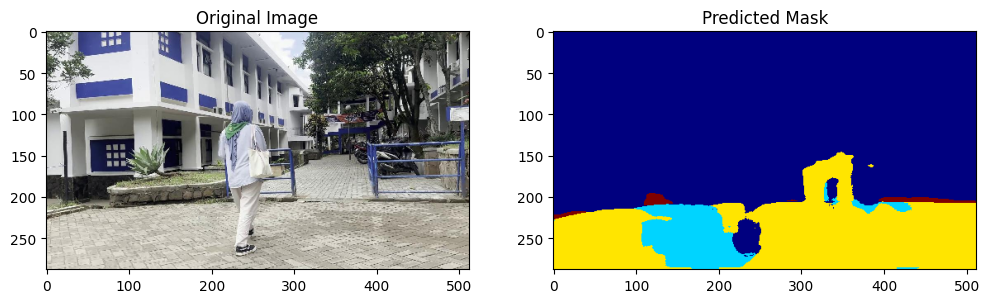

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

# Path to the test image and model
test_image_path = '/content/drive/MyDrive/datasetld3kelas/test/image_1077_jpg.rf.218e1ee862bc0ef1e7a70bbb94bc553c.jpg'  # Update with your test image path
best_model_path = '/content/drive/MyDrive/datasetld3kelas/best_model.keras'

# Redefine global parameters
img_height, img_width = 288, 512
batch_size = 8  # Match with training batch size

# Load the trained model
print("Loading the best model...")
model = tf.keras.models.load_model(best_model_path)

# Load and preprocess the test image
def preprocess_image(image_path, target_size):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    image_array = tf.keras.preprocessing.image.img_to_array(image) / 255.0
    return np.expand_dims(image_array, axis=0), image_array  # Add batch dimension and return original image for visualization

# Preprocess the test image
print("Preprocessing test image...")
input_image, original_image = preprocess_image(test_image_path, (img_height, img_width))

# Run prediction
print("Running prediction...")
prediction = model.predict(input_image)
predicted_mask = np.argmax(prediction[0], axis=-1)  # Convert probabilities to class indices

# Visualize the result
def visualize_result(original_image, predicted_mask):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(predicted_mask, cmap='jet')  # Using colormap for better visualization

    plt.show()

print("Visualizing result...")
visualize_result(original_image, predicted_mask)

#merah jalan, biru muda trotoar, biru tua base, kuning belok, ijo tanjak
